In [1]:
import pylab as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr.isrTask import IsrTask
from lsst.cp.pipe.cpCombine import CalibCombineTask
import traceback
import numpy as np
import pandas as pd
from lsst.ip.isr import vignette
import lsst.cp

Defining a helper function to plot images

In [2]:
afwDisplay.setDefaultBackend('matplotlib') 

def display(exposure,title=None,frame=1):
    afw_display = afwDisplay.Display(frame)
#    afw_display.scale('asinh', 'zscale')
    afw_display.scale('asinh', 0, 1000)
    afw_display.mtv(exposure.getImage())
    # plt.title(title)
    return afw_display
   # plt.gca().axis('off')

In [23]:
def pixelPercent(number):
    '''

    '''
    total = 4000*4072
    return 100*number/total

In [26]:
repo_path = "embargo_new" # The path where the data taken in the ir2 cleanroom is stored
butler = Butler(repo_path) # Initializing a Butler
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
butler = Butler(repo_path,collections=collections) # Initializing a butler with the ir2 path and the above collections
registry = butler.registry # converting the butler to a RegistryShim to query the datatypes

In [28]:
registry.queryCollections("*E1146*")

[]

In [13]:
# collections = 'u/lsstccs/defects_13550_w_2023_41' # selecting the one collection name that has 'defects' in it for 13550 - Run 6b
# collections = 'u/lsstccs/defects_13401_w_2023_24' # selecting the one collection name that has 'defects' in it for 13401 - Run 6

In [14]:
for results in butler.registry.queryDatasets(...,collections=collections).byParentDatasetType(): # querying datasets using a butler on the defects collection
    n=results.count(exact=False) # Counting the number of files in the directory
    if n==0: # If the directory is empty
        continue
    print(results.parentDatasetType.name, n) # Otherwise, print the name of the parentDatasetType and the number of entries

camera 1
raw 12074267
crosstalk 205
transmission_sensor 189


In [8]:
kwargs={
"datasetType": "defects",
"collections": collections,
"where":
"""
instrument='LSSTCam' 
"""
}

# Defining the datasetType as 'defects' is the crucial step here

datasetRefs = list(registry.queryDatasets(**kwargs)) # a datasetRef (A DatasetType and a DataID bundled together that describes
# loading a specific piece of data) of the defects using the args above

print( f"You have {len(datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 205 in this repository with the condition supplied {'datasetType': 'defects', 'collections': 'u/lsstccs/defects_13401_w_2023_24', 'where': "\ninstrument='LSSTCam' \n"}


Now, querying both run 6 and 6b for defects

In [9]:
collection_names = ['u/lsstccs/defects_13401_w_2023_24','u/lsstccs/defects_13550_w_2023_41']

run_label = ['Run_6','Run_6b']

observable = ['_pix_count','_percent_defect']

iter = 0

detector_nums = np.arange(0,len(datasetRefs))

compDF = pd.DataFrame(data=0,
                      columns=['Run_6_pix_count','Run_6_percent_defect','Run_6b_pix_count','Run_6b_percent_defect'],
                      index = detector_nums)

compDF[compDF.columns.values[[1,3]]] = compDF[compDF.columns.values[[1,3]]].astype(float)

In [10]:
compDF

,Run_6_pix_count,Run_6_percent_defect,Run_6b_pix_count,Run_6b_percent_defect
0,0,0.0,0,0.0
1,0,0.0,0,0.0
2,0,0.0,0,0.0
3,0,0.0,0,0.0
4,0,0.0,0,0.0
...,...,...,...,...
200,0,0.0,0,0.0
201,0,0.0,0,0.0
202,0,0.0,0,0.0
203,0,0.0,0,0.0


In [11]:
iter = 0

for fname in collection_names:

    temp_run_label = run_label[iter]

    # Query
    
    kwargs={
    "datasetType": "defects",
    "collections": fname,
    "where":
    """
    instrument='LSSTCam' 
    """
    }
    
    datasetRefs = list(registry.queryDatasets(**kwargs))

    # For each entry in datasetRefs
    
    for ref in datasetRefs:
        # print(ref.dataId)
        mask=butler.get(ref)
        table = mask.toTable()[0]
        cumnum = 0
        for entry in table:
            cumnum += entry['width']*entry['height']
    
        # Store cumnum, ref.dataId['detector'], and pixelPercent(cumnum) for each data run

        compDF.at[ref.dataId['detector'],run_label[iter]+observable[1]] = pixelPercent(cumnum) # Percent
        compDF.at[ref.dataId['detector'],run_label[iter]+observable[0]] = cumnum
        
        ### Testing
        # printf("For detector ", ref.dataId['detector'],", a total of ",cumnum," pixels registered defects. This is ","{:.4f}".format(pixelPercent(cumnum)),"% of the detector.",sep='')
        # for entry in mask:
        #     if entry.getType()!=0:
        #         print(entry.getType())
        ### End Testing
    
    
    
    iter+=1

In [12]:
# Computing differences

compDF['pix_difference'] = compDF["Run_6_pix_count"] - compDF["Run_6b_pix_count"]
compDF['percent_difference'] = compDF["Run_6_percent_defect"] - compDF["Run_6b_percent_defect"]
# run_label[iter]+observable[1]

# Plots of crude statistics

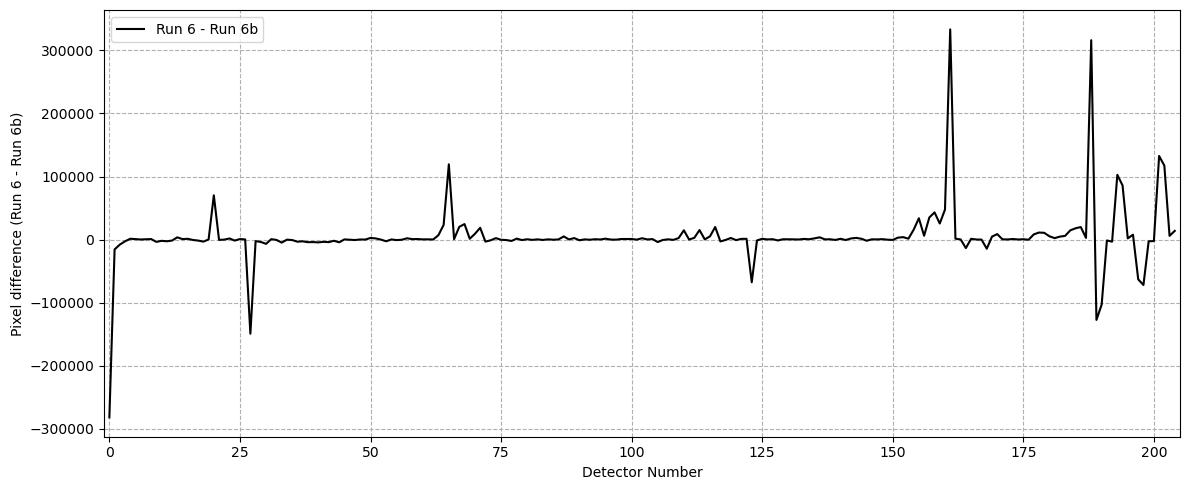

In [13]:
fig,ax = plt.subplots(figsize=[12,5])

ax.plot(compDF.index,compDF["pix_difference"],label='Run 6 - Run 6b',c='black')
ax.set_xlim(left = -1,right=max(compDF.index)+1)
ax.set_xlabel("Detector Number")
ax.set_ylabel("Pixel difference (Run 6 - Run 6b)")
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

# fig.savefig("Figures/CrudeStats/Pixel_difference_No_types.jpg",dpi=100)

plt.show()

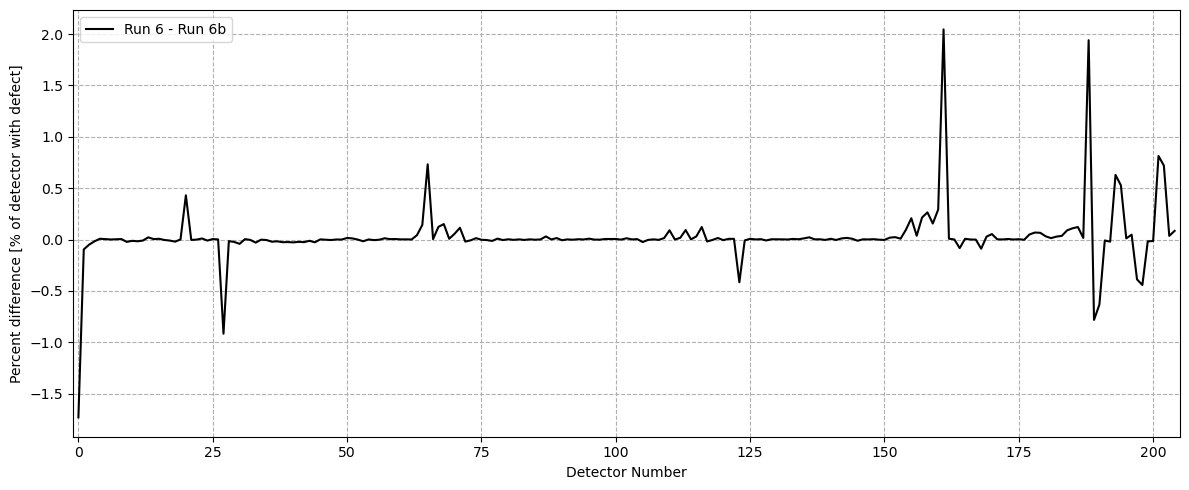

In [14]:
fig,ax = plt.subplots(figsize=[12,5])

ax.plot(compDF.index,compDF["percent_difference"],label='Run 6 - Run 6b',c='black')
ax.set_xlim(left = -1,right=max(compDF.index)+1)
ax.set_xlabel("Detector Number")
ax.set_ylabel("Percent difference [% of detector with defect]")
plt.legend()
ax.grid(ls='--')

fig.tight_layout()

# fig.savefig("Figures/CrudeStats/Percent_difference_No_types.jpg",dpi=100)

plt.show()

fig.clear()
plt.close(fig)

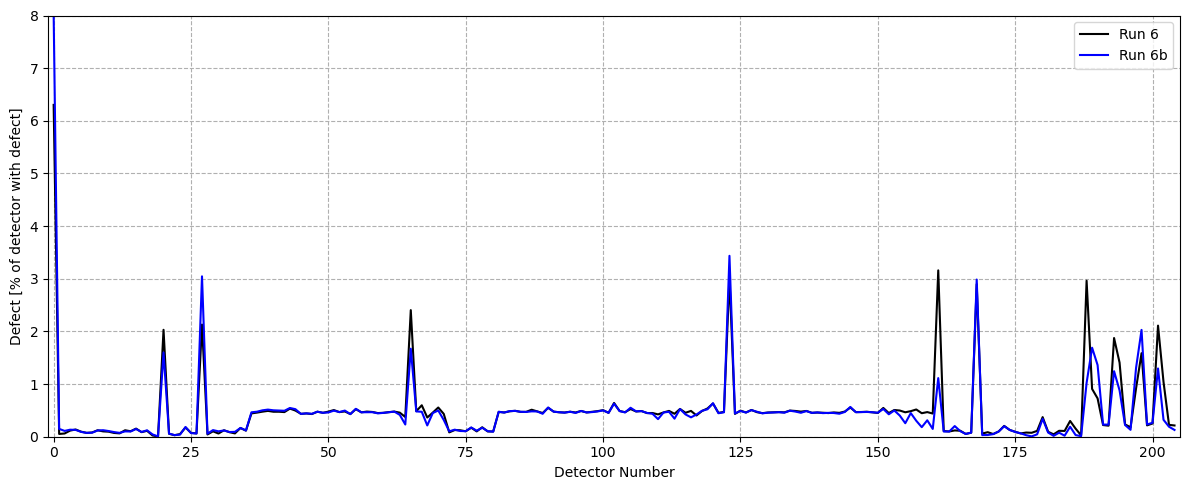

In [15]:
fig,ax = plt.subplots(figsize=[12,5])

ax.plot(compDF.index,compDF["Run_6_percent_defect"],label='Run 6',c='black')
ax.plot(compDF.index,compDF["Run_6b_percent_defect"],label='Run 6b',c='blue')
ax.set_xlim(left = -1,right=max(compDF.index)+1)
ax.set_xlabel("Detector Number")
ax.set_ylabel("Defect [% of detector with defect]")
plt.legend()
ax.grid(ls='--')
ax.set_ylim(0,8)

fig.tight_layout()

fig.savefig("Figures/CrudeStats/Percent_difference_Runs_No_types.jpg",dpi=100)

plt.show()

fig.clear()
plt.close(fig)

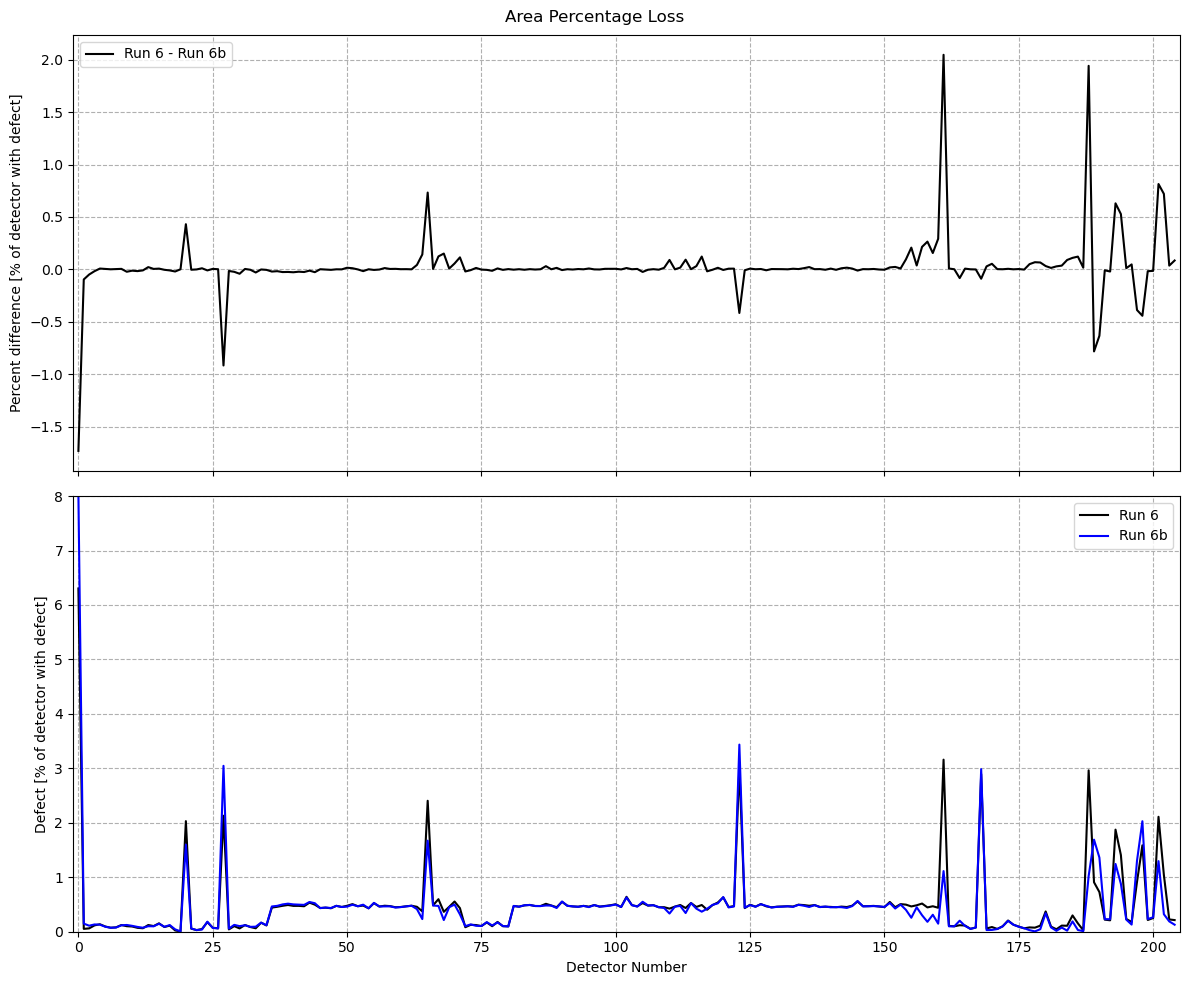

In [16]:
fig,axs = plt.subplots(2,1,figsize=[12,10],sharex=True)

axs[0].plot(compDF.index,compDF["percent_difference"],label='Run 6 - Run 6b',c='black')
axs[0].set_xlim(left = -1,right=max(compDF.index)+1)
# axs[0].set_xlabel("Detector Number")
axs[0].set_ylabel("Percent difference [% of detector with defect]")
axs[0].legend()
axs[0].grid(ls='--')

axs[1].plot(compDF.index,compDF["Run_6_percent_defect"],label='Run 6',c='black')
axs[1].plot(compDF.index,compDF["Run_6b_percent_defect"],label='Run 6b',c='blue')
axs[1].set_xlim(left = -1,right=max(compDF.index)+1)
axs[1].set_xlabel("Detector Number")
axs[1].set_ylabel("Defect [% of detector with defect]")
axs[1].legend()
axs[1].grid(ls='--')
axs[1].set_ylim(0,8)

fig.suptitle("Area Percentage Loss")

fig.tight_layout()

fig.savefig("Figures/CrudeStats/Percent_Runs_No_types.jpg",dpi=100)

plt.show()

fig.clear()
plt.close(fig)

# Now, let's flag all the notable detectors

To do this, let's look at any detector with defect area greater than 1% of the detector size, or with any difference in are >0.5%, in either run 6 or 6b

In [17]:
detector_arr = np.array([],dtype=int)

for index in compDF.index:
    if (compDF.iloc[index]["Run_6_percent_defect"]>1 or compDF.iloc[index]["Run_6b_percent_defect"]>1 or np.abs(compDF.iloc[index]["percent_difference"])>0.5):
        detector_arr = np.append(detector_arr,index)
    # print(compDF.iloc[index])

In [19]:
detector_arr

array([  0,  20,  27,  65, 123, 161, 168, 188, 189, 190, 193, 194, 197,
       198, 201, 202])

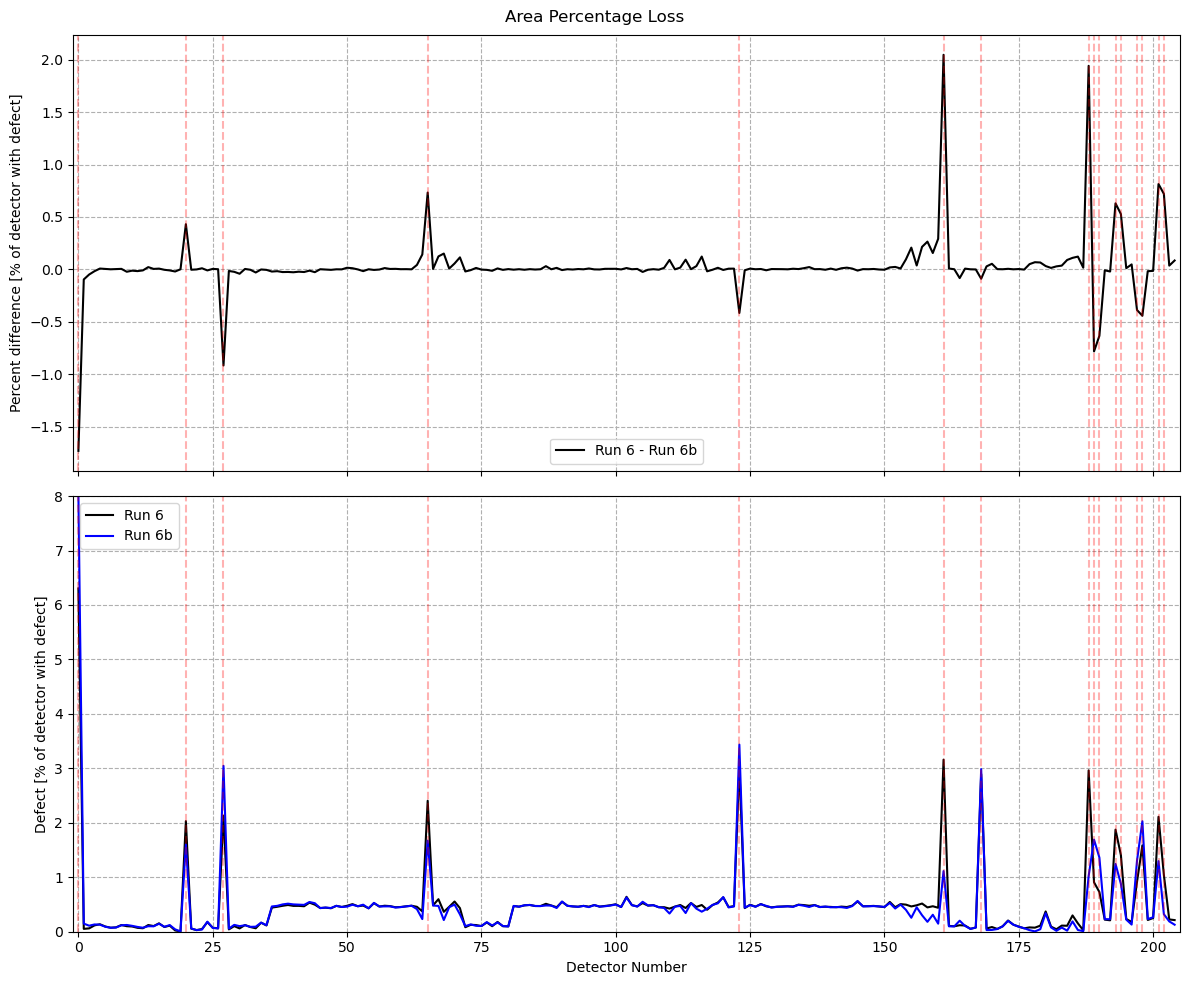

In [18]:
fig,axs = plt.subplots(2,1,figsize=[12,10],sharex=True)

axs[0].plot(compDF.index,compDF["percent_difference"],label='Run 6 - Run 6b',c='black')
axs[0].set_xlim(left = -1,right=max(compDF.index)+1)
# axs[0].set_xlabel("Detector Number")
axs[0].set_ylabel("Percent difference [% of detector with defect]")
axs[0].legend()
axs[0].grid(ls='--')

axs[1].plot(compDF.index,compDF["Run_6_percent_defect"],label='Run 6',c='black')
axs[1].plot(compDF.index,compDF["Run_6b_percent_defect"],label='Run 6b',c='blue')
axs[1].set_xlim(left = -1,right=max(compDF.index)+1)
axs[1].set_xlabel("Detector Number")
axs[1].set_ylabel("Defect [% of detector with defect]")
axs[1].legend()
axs[1].grid(ls='--')
axs[1].set_ylim(0,8)

for detector in detector_arr:
    axs[0].axvline(detector,color='red',alpha=0.3,ls='--')
    axs[1].axvline(detector,color='red',alpha=0.3,ls='--')

fig.suptitle("Area Percentage Loss")

fig.tight_layout()

fig.savefig("Figures/CrudeStats/Percent_Runs_No_types_Issue_detectors.jpg",dpi=100)

plt.show()

fig.clear()
plt.close(fig)

# Now, investigate the bias frames of both of the runs

In [19]:
bias_names = ['u/lsstccs/bias_13401_w_2023_24','u/lsstccs/bias_13550_w_2023_41']

run_label = ['Run_6','Run_6b']

# observable = ['_pix_count','_percent_defect']

iter = 0

detector_nums = np.arange(0,len(datasetRefs))

fig_kwargs = {
    "vmin": 0,
    "vmax": 10000,
    "norm": "asinh"
}

In [56]:
for detector in detector_arr:
    iter = 0   
    # Create figure
    fig,axs = plt.subplots(1,2,figsize=[12,6],sharey=True)
    
    fig.suptitle("Detector {var} bias".format(var=detector))
    for fname in bias_names:

        # Query

        temp_run_label = run_label[iter]

        kwargs={
        "datasetType": "bias",
        "collections": fname,
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve bias of detector # detector

        datasetRefs = list(registry.queryDatasets(**kwargs))
        img = butler.get(datasetRefs[0])

        # Display image in axs[iter]

        axs[iter].imshow(img.image.getArray(),cmap="gray",origin="lower",**fig_kwargs)
        axs[iter].set_title(temp_run_label)
        axs[iter].set_yticks(np.arange(0,4001,step=500))

        if iter==1:
            diff_arr = img_arr - img.image.getArray()
        
        img_arr = img.image.getArray()
        
        iter+=1

    # Finished with first figure, now format it

    for ax in axs:
        ax.set_xlabel("X Pixel")
    axs[0].set_ylabel("Y Pixel")

    fig.tight_layout()

    # Save first figure here

    fig.savefig("Figures/Bias images/Bias_comparison_detector_{var}.jpg".format(var=detector),dpi=100)

    fig.clear()
    plt.close(fig)
    
    # Format new figure

    fig,ax = plt.subplots(1,1,figsize=[7,6])

    fig.suptitle("Detector {var} bias: Run 6 - Run 6b".format(var=detector))

    cax = ax.imshow(diff_arr,cmap="gray",origin="lower")
    ax.set_yticks(np.arange(0,4001,step=500))

    for ax in axs:
        ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")
    im_ratio = diff_arr.shape[0]/diff_arr.shape[1]
    fig.colorbar(cax,label="Flux difference [e-]",fraction=0.046*im_ratio, pad=0.04)
    fig.tight_layout()

    # Save here

    fig.savefig("Figures/Bias images/Bias_difference_detector_{var}.jpg".format(var=detector),dpi=100)

    fig.clear()
    plt.close(fig)

# Now, investigate the flat frames of both of the runs

In [22]:
flat_names = ['u/lsstccs/flat_13401_w_2023_24','u/lsstccs/flat_13550_w_2023_41']

run_label = ['Run_6','Run_6b']

# observable = ['_pix_count','_percent_defect']

iter = 0

detector_nums = np.arange(0,len(datasetRefs))

fig_kwargs = {
    "vmin": 10000,
    "vmax": 106187,
    "norm": "asinh"
}

In [58]:
for detector in [detector_arr[-4]]:
    iter = 0   
    # Create figure
    fig,axs = plt.subplots(1,2,figsize=[12,6],sharey=True)
    
    fig.suptitle("Detector {var} flat".format(var=detector))
    for fname in flat_names:

        # Query

        temp_run_label = run_label[iter]

        kwargs={
        "datasetType": "flat",
        "collections": fname,
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve bias of detector # detector

        datasetRefs = list(registry.queryDatasets(**kwargs))
        img = butler.get(datasetRefs[0])

        # Display image in axs[iter]

        axs[iter].imshow(img.image.getArray(),cmap="gray",origin="lower",**fig_kwargs)
        axs[iter].set_title(temp_run_label)
        axs[iter].set_yticks(np.arange(0,4001,step=500))

        if iter==1:
            diff_arr = img_arr - img.image.getArray()
        
        img_arr = img.image.getArray()
        
        iter+=1

    # Finished with first figure, now format it

    for ax in axs:
        ax.set_xlabel("X Pixel")
    axs[0].set_ylabel("Y Pixel")

    fig.tight_layout()

    # Save first figure here

    fig.savefig("Figures/Flat images/Flat_comparison_detector_{var}.jpg".format(var=detector),dpi=100)
    
    fig.clear()
    plt.close(fig)
    
    # Format new figure

    fig,ax = plt.subplots(1,1,figsize=[7,6])

    fig.suptitle("Detector {var} flat: Run 6 - Run 6b".format(var=detector))

    cax = ax.imshow(diff_arr,cmap="gray",origin="lower")
    ax.set_yticks(np.arange(0,4001,step=500))

    for ax in axs:
        ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")
    im_ratio = diff_arr.shape[0]/diff_arr.shape[1]
    fig.colorbar(cax,label="Flux difference [e-]",fraction=0.046*im_ratio, pad=0.04)
    fig.tight_layout()

    # Save here

    fig.savefig("Figures/Flat images/Flat_difference_detector_{var}.jpg".format(var=detector),dpi=100)

    fig.clear()
    plt.close(fig)

# Now, investigate the dark frames of both of the runs

In [23]:
dark_names = ['u/lsstccs/dark_13401_w_2023_24','u/lsstccs/dark_13550_w_2023_41']

run_label = ['Run_6','Run_6b']

# observable = ['_pix_count','_percent_defect']

iter = 0

detector_nums = np.arange(0,len(datasetRefs))

fig_kwargs = {
    "vmin": 0,
    "vmax": 4000,
    "norm": "asinh"
}

In [60]:
for detector in detector_arr:
    iter = 0   
    # Create figure
    fig,axs = plt.subplots(1,2,figsize=[12,6],sharey=True)
    
    fig.suptitle("Detector {var} dark".format(var=detector))
    for fname in dark_names:

        # Query

        temp_run_label = run_label[iter]

        kwargs={
        "datasetType": "dark",
        "collections": fname,
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve bias of detector # detector

        datasetRefs = list(registry.queryDatasets(**kwargs))
        img = butler.get(datasetRefs[0])

        # Display image in axs[iter]

        axs[iter].imshow(img.image.getArray(),cmap="gray",origin="lower",**fig_kwargs)
        axs[iter].set_title(temp_run_label)
        axs[iter].set_yticks(np.arange(0,4001,step=500))

        if iter==1:
            diff_arr = img_arr - img.image.getArray()
        
        img_arr = img.image.getArray()
        
        iter+=1

    # Finished with first figure, now format it

    for ax in axs:
        ax.set_xlabel("X Pixel")
    axs[0].set_ylabel("Y Pixel")

    fig.tight_layout()

    # Save first figure here

    fig.savefig("Figures/Dark images/Dark_comparison_detector_{var}.jpg".format(var=detector),dpi=100)

    fig.clear()
    plt.close(fig)
    
    # Format new figure

    fig,ax = plt.subplots(1,1,figsize=[7,6])

    fig.suptitle("Detector {var} dark: Run 6 - Run 6b".format(var=detector))

    cax = ax.imshow(diff_arr,cmap="gray",origin="lower")
    ax.set_yticks(np.arange(0,4001,step=500))

    for ax in axs:
        ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")
    im_ratio = diff_arr.shape[0]/diff_arr.shape[1]
    fig.colorbar(cax,label="Flux difference [e-]",fraction=0.046*im_ratio, pad=0.04)
    fig.tight_layout()

    # Save here

    fig.savefig("Figures/Dark images/Dark_difference_detector_{var}.jpg".format(var=detector),dpi=100)

    fig.clear()
    plt.close(fig)

# Now, investigate the raw frames of both of the runs

In [24]:
raw_names = ['u/lsstccs/raw_13401_w_2023_24','u/lsstccs/raw_13550_w_2023_41']

run_label = ['Run_6','Run_6b']

# observable = ['_pix_count','_percent_defect']

iter = 0

detector_nums = np.arange(0,len(datasetRefs))

fig_kwargs = {
    "vmin": 0,
    "vmax": 4000,
    "norm": "asinh"
}

MissingCollectionError: No collection with name 'u/lsstccs/raw_13401_w_2023_24' found.

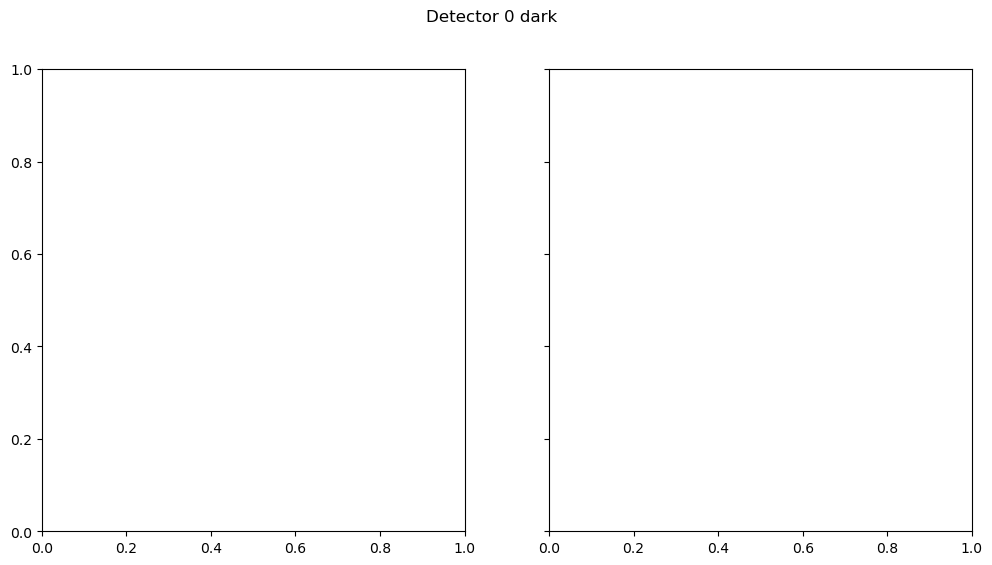

In [62]:
for detector in [detector_arr[0]]:
    iter = 0   
    # Create figure
    fig,axs = plt.subplots(1,2,figsize=[12,6],sharey=True)
    
    fig.suptitle("Detector {var} dark".format(var=detector))
    for fname in raw_names:

        # Query

        temp_run_label = run_label[iter]

        kwargs={
        "datasetType": "raw",
        "collections": fname,
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve bias of detector # detector

        datasetRefs = list(registry.queryDatasets(**kwargs))
        img = butler.get(datasetRefs[0])

        # Display image in axs[iter]

        axs[iter].imshow(img.image.getArray(),cmap="gray",origin="lower",**fig_kwargs)
        axs[iter].set_title(temp_run_label)
        axs[iter].set_yticks(np.arange(0,4001,step=500))

        if iter==1:
            diff_arr = img_arr - img.image.getArray()
        
        img_arr = img.image.getArray()
        
        iter+=1

    # Finished with first figure, now format it

    for ax in axs:
        ax.set_xlabel("X Pixel")
    axs[0].set_ylabel("Y Pixel")

    fig.tight_layout()

    # Save first figure here

    fig.savefig("Figures/Raw images/Raw_comparison_detector_{var}.jpg".format(var=detector),dpi=100)

    fig.clear()
    plt.close(fig)
    
    # Format new figure

    fig,ax = plt.subplots(1,1,figsize=[7,6])

    fig.suptitle("Detector {var} raw: Run 6 - Run 6b".format(var=detector))

    cax = ax.imshow(diff_arr,cmap="gray",origin="lower")
    ax.set_yticks(np.arange(0,4001,step=500))

    for ax in axs:
        ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")
    im_ratio = diff_arr.shape[0]/diff_arr.shape[1]
    fig.colorbar(cax,label="Flux difference [e-]",fraction=0.046*im_ratio, pad=0.04)
    fig.tight_layout()

    # Save here

    fig.savefig("Figures/Raw images/raw_difference_detector_{var}.jpg".format(var=detector),dpi=100)

    fig.clear()
    plt.close(fig)

# Quick check of two detectors
- 194 - Check for aliasing problem near edge of bias diff image
For 194, this issue appears in all diff images, so this is not a unique issue. Something with the aliasing of the axes tick labels
- 197 - regenerate the comparison image with different contrast limits
197 shows a uniform region in run 6, but a cold spot in run 6b - not a dust spot in 6 and the dust spot moved in 6b

In [25]:
x_lim = [2500,3500]
y_lim = [1000,2000]

In [26]:
flat_names = ['u/lsstccs/flat_13401_w_2023_24','u/lsstccs/flat_13550_w_2023_41']

run_label = ['Run_6','Run_6b']

# observable = ['_pix_count','_percent_defect']

iter = 0

detector_nums = np.arange(0,len(datasetRefs))

fig_kwargs = {
    "vmin": 10000,
    "vmax": 106187,
    "norm": "asinh"
}

In [65]:
for detector in [detector_arr[-4]]:
    iter = 0   
    # Create figure
    fig,axs = plt.subplots(1,2,figsize=[12,6],sharey=True)
    
    fig.suptitle("Detector {var} flat".format(var=detector))
    for fname in flat_names:

        # Query

        temp_run_label = run_label[iter]

        kwargs={
        "datasetType": "flat",
        "collections": fname,
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve bias of detector # detector

        datasetRefs = list(registry.queryDatasets(**kwargs))
        img = butler.get(datasetRefs[0])

        # Display image in axs[iter]

        axs[iter].imshow(img.image.getArray(),cmap="gray",origin="lower",**fig_kwargs)
        axs[iter].set_title(temp_run_label)
        axs[iter].set_yticks(np.arange(0,4001,step=500))

        if iter==1:
            diff_arr = img_arr - img.image.getArray()
        
        img_arr = img.image.getArray()
        
        iter+=1

    # Finished with first figure, now format it

    for ax in axs:
        ax.set_xlabel("X Pixel")
        # ax.set_xlim(x_lim)
        # ax.set_ylim(y_lim)
    axs[0].set_ylabel("Y Pixel")

    fig.tight_layout()

    # Save first figure here

    fig.savefig("Figures/Flat images/Flat_comparison_detector_{var}_inset.jpg".format(var=detector),dpi=180)
    
    fig.clear()
    plt.close(fig)
    
    # Format new figure

    fig,ax = plt.subplots(1,1,figsize=[7,6])

    fig.suptitle("Detector {var} flat: Run 6 - Run 6b".format(var=detector))

    cax = ax.imshow(diff_arr,cmap="gray",origin="lower")
    ax.set_yticks(np.arange(0,4001,step=500))

    im_ratio = diff_arr.shape[0]/diff_arr.shape[1]
    # for ax in ax:
    ax.set_xlabel("X Pixel")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_ylabel("Y Pixel")
    fig.colorbar(cax,label="Flux difference [e-]",fraction=0.046*im_ratio, pad=0.04)
    fig.tight_layout()

    # Save here

    fig.savefig("Figures/Flat images/Flat_difference_detector_{var}_inset.jpg".format(var=detector),dpi=180)

    fig.clear()
    plt.close(fig)

# Now, let's directly look at the masks from 6b and 6b

In [40]:
collections = ['u/lsstccs/defects_13401_w_2023_24','u/lsstccs/defects_13550_w_2023_41'] # selecting the one collection name that has 'defects' in it - run 6 and 6b

In [41]:
for results in butler.registry.queryDatasets(...,collections=collections).byParentDatasetType(): # querying datasets using a butler on the defects collection
    n=results.count(exact=False) # Counting the number of files in the directory
    if n==0: # If the directory is empty
        continue
    print(results.parentDatasetType.name, n) # Otherwise, print the name of the parentDatasetType and the number of entries

camera 1
raw 12059833
cpBiasProc 8200
isr_metadata 25625
bias 410
isr_config 9
packages 9
isr_log 25625
cpBiasCombine_config 2
cpBiasCombine_metadata 410
cpBiasCombine_log 410
cpFlatMeasure_config 2
cpFlatCombine_config 2
cpFlatNorm_config 2
cpFlatProc 4100
flatStats 4100
cpFlatNormScales 2
cpFlatMeasure_metadata 4100
cpFlatMeasure_log 4100
flat 410
cpFlatCombine_metadata 410
cpFlatCombine_log 410
cpFlatNorm_metadata 2
cpFlatNorm_log 2
cpDark_config 3
cpDarkCombine_config 3
cpDarkIsr 5535
cpDarkProc 5535
cpDark_metadata 5535
cpDark_log 5535
dark 615
cpDarkCombine_metadata 615
cpDarkCombine_log 615
measureDefects_config 2
mergeDefects_config 2
cpDefectsProc 7790
cpPartialDefects 7790
measureDefects_metadata 7790
measureDefects_log 7790
defects 410
mergeDefects_metadata 410
mergeDefects_log 410


In [42]:
kwargs={
"datasetType": "defects",
"collections": collections,
"where":
"""
instrument='LSSTCam' 
"""
}

# Defining the datasetType as 'defects' is the crucial step here

datasetRefs = list(registry.queryDatasets(**kwargs)) # a datasetRef (A DatasetType and a DataID bundled together that describes
# loading a specific piece of data) of the defects using the args above

print( f"You have {len(datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 410 in this repository with the condition supplied {'datasetType': 'defects', 'collections': ['u/lsstccs/defects_13401_w_2023_24', 'u/lsstccs/defects_13550_w_2023_41'], 'where': "\ninstrument='LSSTCam' \n"}


In [43]:
dir(datasetRefs[0])

['__annotations__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_datastore_records',
 '_id',
 '_lookupNames',
 '_serializedType',
 '_unpickle',
 'dataId',
 'datasetType',
 'dimensions',
 'expanded',
 'from_json',
 'from_simple',
 'groupByType',
 'id',
 'isComponent',
 'isComposite',
 'is_compatible_with',
 'iter_by_type',
 'makeComponentRef',
 'makeCompositeRef',
 'overrideStorageClass',
 'replace',
 'run',
 'to_json',
 'to_simple']

In [44]:
mask = butler.get(datasetRefs[0])

In [45]:
dir(mask)

['_OBSTYPE',
 '_SCHEMA',
 '_VERSION',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_bulk_update',
 '_calibId',
 '_check_value',
 '_defects',
 '_detectorId',
 '_detectorName',
 '_detectorSerial',
 '_filter',
 '_get_values',
 '_instrument',
 '_metadata',
 '_normalize',
 '_raftName',
 '_requiredAttributes',
 '_seqcksum',
 '_seqfile',
 '_seqname',
 '_slotName',
 'append',
 'apply',
 'bulk_update',
 'calibInfoFromDict',
 'copy',
 'determineCalibClass',
 'fromDetector',
 'fromDict',
 'fromFootprintList',
 'fromMask',
 'fromTable',


In [46]:
mask.toFitsRegionTable()

X,Y,SHAPE,R,ROTANG,COMPONENT
float64,float64,str5,float64[2],float64,int64
34.0,8.0,POINT,1.0 .. 1.0,0.0,0
37.0,8.0,POINT,1.0 .. 1.0,0.0,1
40.0,8.0,POINT,1.0 .. 1.0,0.0,2
173.0,8.0,POINT,1.0 .. 1.0,0.0,3
190.0,8.0,POINT,1.0 .. 1.0,0.0,4
221.0,8.0,POINT,1.0 .. 1.0,0.0,5
277.0,8.0,POINT,1.0 .. 1.0,0.0,6
280.0,8.0,POINT,1.0 .. 1.0,0.0,7
300.0,8.0,POINT,1.0 .. 1.0,0.0,8


In [47]:
help(mask.maskPixels)

Help on method maskPixels in module lsst.ip.isr.defects:

maskPixels(mask, maskName='BAD') method of lsst.ip.isr.defects.Defects instance
    Set mask plane based on these defects.
    
    Parameters
    ----------
    maskedImage : `lsst.afw.image.MaskedImage` or `lsst.afw.image.Mask`
        Image to process.  Only the mask plane is updated.
    maskName : str, optional
        Mask plane name to use.



## Questions to ask about the masks
- How are the ring artifacts from variable FOV in bias frames treated?

In [20]:
def formatter(display):
    display.setMaskPlaneColor('SATURATED',color='lime')
    display.setMaskPlaneColor('SUSPECT',color='deepskyblue')
    display.setMaskPlaneColor('INTRP',color='hotpink')
    display.setMaskPlaneColor('SAT',color='gold')
    display.setMaskPlaneColor('UNMASKEDNAN',color='darkolivegreen')
    display.setMaskTransparency(1)

In [21]:
file_names = np.array([['u/lsstccs/dark_13401_w_2023_24','u/lsstccs/flat_13401_w_2023_24',
                        'u/lsstccs/bias_13401_w_2023_24','u/lsstccs/defects_13401_w_2023_24'],
                       ['u/lsstccs/dark_13550_w_2023_41','u/lsstccs/flat_13550_w_2023_41',
                        'u/lsstccs/bias_13550_w_2023_41','u/lsstccs/defects_13550_w_2023_41']]) # dark, flat, bias, defect

run_label = ['Run 6','Run 6b']

image_type = [": dark image",": flat image",": bias image",": bias with defect mask"]

In [22]:
# help(mask.maskPixels)

In [23]:
iter = 0

fig = 'mtv'; plt.close(fig); fig = plt.figure(fig)

for detector in detector_arr:
    fig,axs = plt.subplots(2,4,figsize=[20,10],sharex=True,sharey=True)
    fig.suptitle("Detector {var}".format(var=detector))
    # axs = axs.flatten()
    label_iter = 0 
    for fname in file_names:
        temp_run_label = run_label[label_iter]

        # Query darks

        kwargs={
        "datasetType": "dark",
        "collections": fname[0],
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve dark of detector

        datasetRefs_img = list(registry.queryDatasets(**kwargs))
        dark_img = butler.get(datasetRefs_img[0])

        # Query flat

        kwargs={
        "datasetType": "flat",
        "collections": fname[1],
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve flat of detector

        datasetRefs_img = list(registry.queryDatasets(**kwargs))
        flat_img = butler.get(datasetRefs_img[0])

        # Query images

        kwargs={
        "datasetType": "bias",
        "collections": fname[2],
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve bias of detector

        datasetRefs_img = list(registry.queryDatasets(**kwargs))
        bias_img = butler.get(datasetRefs_img[0])

        # query defect

        kwargs={
        "datasetType": "defects",
        "collections": fname[3],
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # get defect mask 

        datasetRefs_mask = list(registry.queryDatasets(**kwargs))
        mask = butler.get(datasetRefs_mask[0])

        # define a function here
        
        def img_return(iter):
            if iter==0:
                return dark_img
            elif iter==1:
                return flat_img
            elif iter==2:
                return bias_img
            elif iter==3:
                mask.maskPixels(bias_img)
                return bias_img
            else:
                print("something went wrong in the iteration of figures!")
                return -1
        
        # Display image
        
        # panel 1 - dark
        for iter in range(4):
            disp = afwDisplay.Display(fig)
            disp.scale('asinh', 'zscale', Q=8)
            
            formatter(disp)
            plt.sca(axs[label_iter,iter])
            disp.mtv(img_return(iter), title=temp_run_label+image_type[iter])

        label_iter += 1
                    
        # fig.suptitle("Detector test")

        # panel 2 - flat

        # panel 3 - bias

        # panel 4 - bias diff img with mask
        
        # mask.maskPixels(img)

        # afw_display = display(img,title=temp_run_label)

        # # img.setMask()

        # axs[iter].imshow(img.getImage().getArray(),cmap="gray",origin="lower")
        # axs[iter].set_title(temp_run_label)
        # axs[iter].set_yticks(np.arange(0,4001,step=500))

        # if iter==1:
        #     diff_arr = img_arr - img.image.getArray()
        
        # img_arr = img.image.getArray()
        
        # iter+=1

    # axs[iter].imshow(diff_arr,cmap="gray",origin="lower",**fig_kwargs)
    # axs[iter].set_title("Run 6 - Run 6b")
    # Add colorbar
    
    fig.tight_layout()
    
    fig.savefig("Figures/WithMasks/AllFrames/With_mask_detector_{var}.jpg".format(var=detector),dpi=180)

    fig.clear()
    plt.close(fig)

<Figure size 640x480 with 0 Axes>

In [25]:
type(fig)

matplotlib.figure.Figure

In [32]:
afwDisplay.Display(fig)

In [33]:
img_return(iter)

# Bias only

In [115]:
iter = 0

fig = 'mtv'; plt.close(fig); fig = plt.figure(fig)

for detector in [detector_arr[0]]:
    fig,axs = plt.subplots(2,2,figsize=[10,10],sharex=True,sharey=True)
    fig.suptitle("Detector {var}".format(var=detector))
    # axs = axs.flatten()
    label_iter = 0 
    for fname in file_names:
        temp_run_label = run_label[label_iter]

        # # Query darks

        # kwargs={
        # "datasetType": "dark",
        # "collections": fname[0],
        # "where":
        # """
        # instrument='LSSTCam' and
        # detector={var}
        # """.format(var=detector)
        # }
        
        # # Retrieve dark of detector

        # datasetRefs_img = list(registry.queryDatasets(**kwargs))
        # dark_img = butler.get(datasetRefs_img[0])

        # # Query flat

        # kwargs={
        # "datasetType": "flat",
        # "collections": fname[1],
        # "where":
        # """
        # instrument='LSSTCam' and
        # detector={var}
        # """.format(var=detector)
        # }
        
        # # Retrieve flat of detector

        # datasetRefs_img = list(registry.queryDatasets(**kwargs))
        # flat_img = butler.get(datasetRefs_img[0])

        # Query images

        kwargs={
        "datasetType": "bias",
        "collections": fname[2],
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # Retrieve bias of detector

        datasetRefs_img = list(registry.queryDatasets(**kwargs))
        bias_img = butler.get(datasetRefs_img[0])

        # query defect

        kwargs={
        "datasetType": "defects",
        "collections": fname[3],
        "where":
        """
        instrument='LSSTCam' and
        detector={var}
        """.format(var=detector)
        }
        
        # get defect mask 

        datasetRefs_mask = list(registry.queryDatasets(**kwargs))
        mask = butler.get(datasetRefs_mask[0])

        # define a function here
        
        def img_return(iter):
            if iter==0
                return bias_img
            elif iter==1:
                mask.maskPixels(bias_img)
                return bias_img
            else:
                print("something went wrong in the iteration of figures!")
                return -1
        
        # Display image
        
        # panel 1 - dark
        for iter in range(2):
            disp = afwDisplay.Display(fig)
            disp.scale('asinh', 'zscale', Q=8)
            
            formatter(disp)
            plt.sca(axs[label_iter,iter])
            disp.mtv(img_return(iter), title=temp_run_label+image_type[iter+2])

        label_iter += 1
                    
        # fig.suptitle("Detector test")

        # panel 2 - flat

        # panel 3 - bias

        # panel 4 - bias diff img with mask
        
        # mask.maskPixels(img)

        # afw_display = display(img,title=temp_run_label)

        # # img.setMask()

        # axs[iter].imshow(img.getImage().getArray(),cmap="gray",origin="lower")
        # axs[iter].set_title(temp_run_label)
        # axs[iter].set_yticks(np.arange(0,4001,step=500))

        # if iter==1:
        #     diff_arr = img_arr - img.image.getArray()
        
        # img_arr = img.image.getArray()
        
        # iter+=1

    # axs[iter].imshow(diff_arr,cmap="gray",origin="lower",**fig_kwargs)
    # axs[iter].set_title("Run 6 - Run 6b")
    # Add colorbar
    
    fig.tight_layout()
    
    fig.savefig("Figures/WithMasks/BiasOnly/Bias_With_mask_detector_{var}.jpg".format(var=detector),dpi=180)

    fig.clear()
    plt.close(fig)

<Figure size 640x480 with 0 Axes>

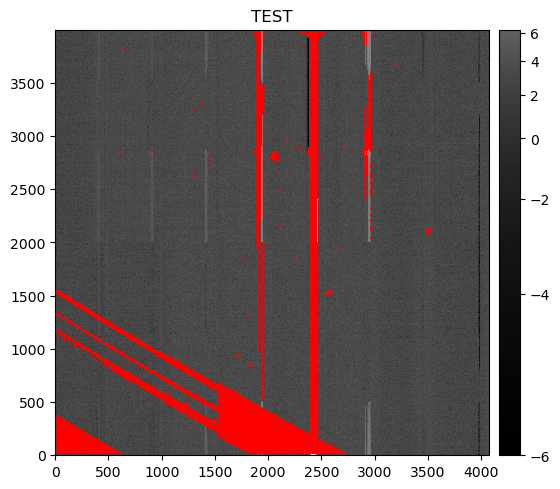

In [116]:
exp = bias_img
fig,ax = plt.subplots(figsize=[6,6])

disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=8)

formatter(disp)
plt.sca(ax)
disp.mtv(exp.getMaskedImage(), title="TEST")

# Break

In [117]:
def vig_update(vig,radius_var,points,xcenter,ycenter):
    vig.update(radius=radius_var)
    vig.update(numPolygonPoints=points)
    vig.update(xCenter=xcenter)
    vig.update(yCenter=ycenter)
    return vig

In [118]:
vig = vignette.VignetteConfig() # create vignette instance

detector_size = 4072

# radius = np.sqrt(2) * (5.5*detector_size)
radius = 4100
points = int(10E2)

vig = vig_update(vig,radius,points,4000,4000)

In [119]:
vigtask = vignette.VignetteTask(vig)

exp =  bias_img #`lsst.afw.image.Exposure`
plane = 'SUSPECT' # `str`, optional. Mask plane to assign vignetted pixels to.
vigVal = 0 # 

polygon = vigtask.run(exposure=exp, maskPlane=plane, vignetteValue=None, log=None)
vignette.maskVignettedRegion(exp,polygon,maskPlane=plane, vignetteValue=None,log=None)

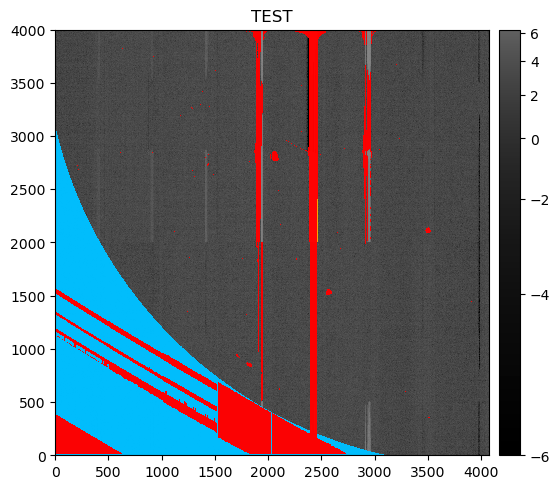

In [120]:
fig,ax = plt.subplots(figsize=[6,6])

disp = afwDisplay.Display(fig)
disp.scale('asinh', 'zscale', Q=8)

formatter(disp)
plt.sca(ax)
disp.mtv(exp.getMaskedImage(), title="TEST")
ax.set_yticks(np.arange(0,4001,step=500));

In [127]:
exp.getMaskedImage().__dir__()

['__init__',
 '__doc__',
 '__module__',
 'swap',
 'assign',
 'subset',
 '__iadd__',
 'scaledPlus',
 '__isub__',
 'scaledMinus',
 '__imul__',
 'scaledMultiplies',
 '__itruediv__',
 'scaledDivides',
 'writeFits',
 'readFits',
 'getImage',
 'setImage',
 'image',
 'getMask',
 'setMask',
 'mask',
 'getVariance',
 'setVariance',
 'variance',
 'getWidth',
 'getHeight',
 'getDimensions',
 'getBBox',
 'getX0',
 'getY0',
 'getXY0',
 'setXY0',
 'indexToPosition',
 'positionToIndex',
 'dtype',
 'set',
 '_set',
 '_get',
 'getArrays',
 'convertF',
 'convertD',
 '__reduce__',
 '__deepcopy__',
 '__str__',
 '__repr__',
 'readFitsWithOptions',
 'writeFitsWithOptions',
 'Factory',
 'clone',
 '__getitem__',
 '__setitem__',
 '__add__',
 '__sub__',
 '__mul__',
 '__truediv__',
 '__radd__',
 '__rsub__',
 '__rmul__',
 '__rtruediv__',
 '__new__',
 '__hash__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__getstate__',


In [104]:
from lsst.afw.cameraGeom import Camera

In [125]:
disp.__dir__()

['frame',
 '_impl',
 'name',
 '_xy0',
 '_maskPlaneColors',
 '_callbacks',
 '__module__',
 '__doc__',
 '_displays',
 '_defaultBackend',
 '_defaultFrame',
 '_defaultMaskPlaneColor',
 '_defaultMaskTransparency',
 '_defaultImageColormap',
 '__init__',
 '__enter__',
 '__exit__',
 '__del__',
 '__getattr__',
 'close',
 'verbose',
 '__str__',
 'setDefaultBackend',
 'getDefaultBackend',
 'setDefaultFrame',
 'getDefaultFrame',
 'incrDefaultFrame',
 'setDefaultMaskTransparency',
 'setDefaultMaskPlaneColor',
 'setDefaultImageColormap',
 'setImageColormap',
 'getDisplay',
 'delAllDisplays',
 'maskColorGenerator',
 'setMaskPlaneColor',
 'getMaskPlaneColor',
 'setMaskTransparency',
 'getMaskTransparency',
 'show',
 '_Display__addMissingMaskPlanes',
 'mtv',
 '_Buffering',
 'Buffering',
 'flush',
 'erase',
 'dot',
 'line',
 'scale',
 'zoom',
 'pan',
 'interact',
 'setCallback',
 'getActiveCallbackKeys',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__getattribute__',
 '__setattr_

# Try to reproduce/understand the pixel list that goes into this eo_pipe result
https://s3df.slac.stanford.edu/data/rubin/lsstcam/13547/w_2023_41/dark_pixels_fp_plot_LSSTCam_u_lsstccs_eo_dark_defects_13547_w_2023_41_20231116T191705Z.png


And then you could focus on the pixels flagged as "Bright" and "Dark" and those columns flagged as "Bright" and "Dark"